# FlowsheetTools.jl Demonstration

FlowsheetTools.jl is a library for dealing with flowsheets (components, streams, unit operations, mass balance boundaries, and flowsheets).
It can be used as a platform for running custom models, for example when fitting kinetic parameters to pilot plant data, where the operating unit is more complicated than a single reactor. The primary intended purpose however, was for process analytics - generating KPIs on a flowsheet and reconciling mass balances for generic flowsheets.

For more convenient analysis of flowsheets with missing measurements, a few utility unit operations are provided: a mixer, a flow splitter, a component splitter (to emulate a separation process with split factors) and a stoichiometric reactor block with specified conversions. Custom unit operations can also be defined, by simply providing a function that calculates the outlet streams from the inlets and an optional list of parameters.

The intention was not to build a full-on process simulator, but the custom reactor blocks etc can be easily added, when needed.

Let's have a look at how to use the library.

In [1]:
using FlowsheetTools
using Statistics: mean

# The Flowsheet

The `Flowsheet` is the central object in FlowsheetTools.jl. It contains a list of unit operations, a list of streams, a list of mass balance boundaries, and a list of components. You need only create the flowsheet. It will manange the other components automatically.
Let's create an empty flowsheet and then build it out.

In [2]:
fs = Flowsheet()

Flowsheet:
UnitOps in Execution Order:

Components:

Streams:

Boundaries:


As you can see, the flowsheet is empty. It has no unit operations, streams, mass balance boundaries, or components yet. You will also see an empty execution order. It is possible to ask the flowsheet to execute all of the unitops it comtains. The execution order sets the order in which they execute.
Remember, that this is not a process simulator. There is no flowsheet convergence algorithm. The unit operations are of the types needed to allow missing information to be calculated to close a mass balance.
These include mixers, various splitters and a simple stoichiometric reactor.

## Components
The most basic building block we need is a set of components. A component in FlowsheetTools.jl is a fairly simple object. It has a name, so we can refer to it, and contains the list of atoms and the number of each that make up the component. The molar mass of the component is automatically calculated and also stored.

We store all the components in a `ComponentList`, so we have a container to find them in, when needed.
You don't need to directly create and manage a `ComponentList`. The `Flowsheet` manages the `ComponentList` for you.
`ComponentList` is a wrapper around a Dict{String, Component} and can be in the same way as such any `Dict` in Julia, using the component names to index. Now that we have a container to put them into, we can add some components.

Let's look at the component list we have in our flowsheet:

In [3]:
fs.comps

Component list:


Not much to see. Just an empty list. Let's add some components.

Since it is likely that we shall re-use components, they can be stored in files, so we don't need to define them every time. Let's read in some components created earlier and stored in the sub-folder `components` under the active folder:

In [4]:
count = readcomponentlist!(fs, "components", ["Ethylene", "Ethane", "Hydrogen"])

3

The function `readcomponents` returns the number of components read in - 3 in this case. We specified the names of the components to read in from the folder. There can be any number of files stored there. We also supplied the flowsheet (`fs`) as the first argument.
Since reading in components modifies (mutates) the flowsheet, the function name is ended in an exclamation mark, as is the convention in Julia.

In [5]:
fs.comps

Component list:
  Ethylene
  Ethane
  Hydrogen


Now we have three components in our flowsheet.
To access a component in the component list, we index using the name of the component.

In [6]:
fs.comps["Ethylene"]

Component: Ethylene

  Atom		Count
---------------------
   C 		   2
   H 		   4


If we need to define new components, ther are two ways to go about this.

The first is by using the @comp macro. It takes a list of atoms and a number of each, separated by a -->. We also suply a name for the component, so we can find it in the `ComponentList` it will be stored in, and the name of the `Flowsheet` to which this `ComponentList` belongs.

In [7]:
@comp begin
    N --> 2
end "Nitrogen" fs

Component: Nitrogen

  Atom		Count
---------------------
   N 		   2


And we can check that is was added to our flowsheet:

In [8]:
fs.comps

Component list:
  Ethylene
  Ethane
  Hydrogen
  Nitrogen


The second way is to create the components by calling the constructor directly. This is most useful when creating lists of components, such a homologous series. For example, we could create the n-paraffins from C1 to C10 as follows:

In [9]:
cl = ComponentList() # Create a new component list that is NOT in our flowsheet. We are throwing this away when we are done.
for n in 1:10
    if n == 1
        name = "CH4"
    else
        name = "C$(n)H$(2n+2)"
    end
    cl[name] = Component(name, ["C", "H"], [n, 2n+2])
end
cl

Component list:
  CH4
  C2H6
  C3H8
  C4H10
  C5H12
  C6H14
  C7H16
  C8H18
  C9H20
  C10H22


In [10]:
cl["C10H22"]

Component: C10H22

  Atom		Count
---------------------
   C 		  10
   H 		  22


Here we created a "dummy" component list, so as to not add these components to our flowsheet. If we wanted to add them to the flowsheet, the code would look like this:

In [11]:
for n in 1:10
    if n == 1
        name = "CH4"
    else
        name = "C$(n)H$(2n+2)"
    end
    fs.comps[name] = Component(name, ["C", "H"], [n, 2n+2])
end

In [12]:
fs.comps

Component list:
  Ethylene
  Ethane
  Hydrogen
  Nitrogen
  CH4
  C2H6
  C3H8
  C4H10
  C5H12
  C6H14
  C7H16
  C8H18
  C9H20
  C10H22


We can delete these components again:

In [13]:
deletecomponent!(fs, "CH4")
for n in 2:10
    name = "C$(n)H$(2n+2)"
    deletecomponent!(fs, name)
end

In [14]:
fs.comps

Component list:
  Ethylene
  Ethane
  Hydrogen
  Nitrogen


We can also clear the whole components list by calling `clearcomponents!(fs)`.

As you can see, the internal `ComponentList` in our flowsheet is called `fs.comps`, where `fs` is of course the name of our flowsheet.

We can save the components to file to re-use later. `writecomponents` takes the path to write to, and the specific component to write. It returns the number of bytes written.

In [15]:
writecomponent(joinpath("components/", "Nitrogen.comp"), fs.comps["Nitrogen"])

22

## Streams

Now that we have components, we can create streams for our process. Each stream contains a list of components and their flowrates. You can specify either the mass or moalr flows when creating the stream and the other will be automatically calculated. The constructor will also calculate the flowrates for each type of atom in the stream.

There are two ways in which we would use streams. Either with a single, current value for the flowrate and composition, or with a set of historical values of these. The former is useful for simulations, while the latter is useful for analysis. In either case, the flows are stored in `TimeArrays` from `TimeSeries.jl`. In cases where we only have a single flowrate, this is a simply `TimeArray` of length 1, with a (zero) timestamp asigned to the value.

As was the case with components, we need a container (a stream list) to hold the streams so we have something to iterate through later. Similar to a `ComponentList`, a `StreamList` is a wrapper around a `Dict{String, Stream}`. Again, you do not need to create or manage the `ComponentList`, as the `Flowsheet` will do that for you. You can access the StreamList via `fs.streams`, where `fs` is the `Flowsheet` object.

We can create the streams directly with instantaneous flows using the `@stream` macro.
The first parameter passed to the macro indicates whether the flows are mass or molar flows. Similarly to what we did for components with `@comp`, we then provide a list of components and their flowrates, separated with a -->. We also supply a name for the stream, and the name of the `Flowsheet` to which to add the new stream.
*The units are not specified* - if you assume the mass flows are in kg/h, then the molar equivalent is kmol/hr, but this could as easily be lb/week and lbmole/week.

Here we specify two streams, of identical composition and flows, but by specifying mass flows for the first and molar flows for the second.

In [16]:
@stream mass begin
    "Ethylene" --> 2.8053
    "Ethane" --> 27.06192
    "Hydrogen" --> 2.21738
end "Test" fs

@stream mole begin
    "Ethane" --> 0.9
    "Hydrogen" --> 1.1
    "Ethylene" --> 0.1
end "Product" fs

Stream: Product

┌─────────────┬──────────┬─────────┬──────────┬──────────┐
│             │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │
├─────────────┼──────────┼─────────┼──────────┼──────────┤
│ Mass flows  │   2.8053 │ 27.0619 │  2.21738 │      0.0 │
│ Molar flows │      0.1 │     0.9 │      1.1 │      0.0 │
└─────────────┴──────────┴─────────┴──────────┴──────────┘

Total mass flow: 32.085

┌──────┬────────────┐
│ Atom │ Molar flow │
├──────┼────────────┤
│    C │        2.0 │
│    N │        0.0 │
│    H │        8.0 │
└──────┴────────────┘


One stream here was specified as mass flows, the other as molar flows, but there streams are the same and the missing flows (mass/mole) are calculated automatically in the constructor.
We can quickly check if the molar flows are identical:

In [17]:
fs.streams["Test"].moleflows .≈ fs.streams["Product"].moleflows

1×4 TimeSeries.TimeArray{Bool, 2, Dates.DateTime, BitMatrix} 0000-01-01T00:00:00 to 0000-01-01T00:00:00
┌─────────────────────┬───────────────────┬───────────────┬─────────────────────
│                     │ Ethylene_Ethylene │ Ethane_Ethane │ Hydrogen_Hydrogen  ⋯
├─────────────────────┼───────────────────┼───────────────┼─────────────────────
│ 0000-01-01T00:00:00 │              true │          true │              true  ⋯
└─────────────────────┴───────────────────┴───────────────┴─────────────────────
                                                                1 column omitted

Or, more conveniently, directly with the `≈` or `==` operators.
The `==` operator will insist on identical flows and names, i.e. of a stream passes through a unit unchanged, but gets a new name, '==' will return false when comparing the inlet and outlet.
The `≈` operator will return true if the flows are approximately the same (within numerical precision), and the names are the same.
Due to numerical precision, it is generally not a good idea to use `==` to compare floating point values in any event.

In [18]:
fs.streams["Test"] ≈ fs.streams["Product"]

true

In [19]:
fs.streams["Test"] == fs.streams["Product"]

false

And, for the skeptical members of the audience, we can also check the atomic flows:

In [20]:
all(getindex.(values(fs.streams["Test"].atomflows), "C") .== getindex.(values(fs.streams["Product"].atomflows), "C"))

true

In [21]:
all(getindex.(values(fs.streams["Test"].atomflows), "H") .== getindex.(values(fs.streams["Product"].atomflows), "H"))

true

These comparisons also showed that we can access the flows using the `massflows`, `molarflows` and `atomflows` properties.

In [22]:
fs.streams["Product"].massflows

1×4 TimeSeries.TimeArray{Float64, 2, Dates.DateTime, Matrix{Float64}} 0000-01-01T00:00:00 to 0000-01-01T00:00:00
┌─────────────────────┬──────────┬─────────┬──────────┬──────────┐
│                     │ Ethylene │ Ethane  │ Hydrogen │ Nitrogen │
├─────────────────────┼──────────┼─────────┼──────────┼──────────┤
│ 0000-01-01T00:00:00 │   2.8053 │ 27.0619 │  2.21738 │      0.0 │
└─────────────────────┴──────────┴─────────┴──────────┴──────────┘

In [23]:
fs.streams["Product"].moleflows

1×4 TimeSeries.TimeArray{Float64, 2, Dates.DateTime, Matrix{Float64}} 0000-01-01T00:00:00 to 0000-01-01T00:00:00
┌─────────────────────┬──────────┬────────┬──────────┬──────────┐
│                     │ Ethylene │ Ethane │ Hydrogen │ Nitrogen │
├─────────────────────┼──────────┼────────┼──────────┼──────────┤
│ 0000-01-01T00:00:00 │      0.1 │    0.9 │      1.1 │      0.0 │
└─────────────────────┴──────────┴────────┴──────────┴──────────┘

In [24]:
fs.streams["Product"].atomflows

1×1 TimeSeries.TimeArray{Dict{String, Float64}, 1, Dates.DateTime, Vector{Dict{String, Float64}}} 0000-01-01T00:00:00 to 0000-01-01T00:00:00
┌─────────────────────┬────────────────────────────────────┐
│                     │ atomflows                          │
├─────────────────────┼────────────────────────────────────┤
│ 0000-01-01T00:00:00 │ Dict("C"=>2.0, "N"=>0.0, "H"=>8.0) │
└─────────────────────┴────────────────────────────────────┘

When we want to deal with streams with multiple historic data points, to analyse plant data, we can use the `readstreamhistory` function, to read the stream from a file.

First, let's start with a new, empty stream list, to get rid of the streams we have created earlier. Note that `deletestreams!(fs)` will delete all the streams in the `Flowsheet`, deletestream(fs, name) will delete a single stream.

In [25]:
deletestreams!(fs)
fs.streams

Stream list:

Streams:
	Empty list


Then we in read the streams. We need to specify the folderpath to the CSV files, the name of the stream, the component list in which the components are defined and the stream list to which to add the new stream. We also specify whether the flows in the CSV files are mass or molar flows. `ismoleflow` has a default value of false, so need not be specified for mass flows.

In [26]:
readstreamhistory!(fs, "Feed", joinpath("streamhistories", "FeedStream.csv"); ismoleflow=true)
readstreamhistory!(fs, "Product", joinpath("streamhistories", "ProdStream.csv"); ismoleflow=true)
fs.streams["Feed"]

Stream: Feed

Mass flows:
┌─────────────────────┬──────────┬─────────┬──────────┬──────────┐
│           timestamp │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │
│      Dates.DateTime │  Float64 │ Float64 │  Float64 │  Float64 │
├─────────────────────┼──────────┼─────────┼──────────┼──────────┤
│ 2020-01-01T00:00:00 │  59.1012 │ 30.1711 │  3.99575 │      0.0 │
│ 2020-01-01T06:00:00 │  59.7961 │ 30.4876 │  4.15398 │      0.0 │
│ 2020-01-02T00:00:00 │  61.2996 │ 27.0851 │  4.21259 │      0.0 │
│ 2020-01-02T06:00:00 │  59.5127 │ 29.9669 │  3.93049 │      0.0 │
│ 2020-01-03T00:00:00 │  52.4608 │ 27.3167 │  4.30034 │      0.0 │
│          ⋮          │    ⋮     │    ⋮    │    ⋮     │    ⋮     │
└─────────────────────┴──────────┴─────────┴──────────┴──────────┘
                                                   22 rows omitted

Molar flows:
┌─────────────────────┬──────────┬──────────┬──────────┬──────────┐
│           timestamp │ Ethylene │   Ethane │ Hydrogen │ Nitrogen │
│      Dates.DateTim

In the data files (*.csv), we had columns of data for ethylene, ethane and hydrogen, but our list of components also includes nitrogen.
We automatically set zero flows for amy components not in the file, so all the streams contain all of the components (for our continued sanity...).

We can still add components to the component list after the streams were created. If we do, then we should also call `refreshcomplist(fs)` to add zero flows for all of these new components to the existing streams in the stream list.

In [27]:
@comp begin
    Ar --> 1
end "Argon" fs

refreshcomplist(fs)

fs.streams["Feed"]

Stream: Feed

Mass flows:
┌─────────────────────┬──────────┬─────────┬──────────┬──────────┬─────────┐
│           timestamp │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │   Argon │
│      Dates.DateTime │  Float64 │ Float64 │  Float64 │  Float64 │ Float64 │
├─────────────────────┼──────────┼─────────┼──────────┼──────────┼─────────┤
│ 2020-01-01T00:00:00 │  59.1012 │ 30.1711 │  3.99575 │      0.0 │     0.0 │
│ 2020-01-01T06:00:00 │  59.7961 │ 30.4876 │  4.15398 │      0.0 │     0.0 │
│ 2020-01-02T00:00:00 │  61.2996 │ 27.0851 │  4.21259 │      0.0 │     0.0 │
│ 2020-01-02T06:00:00 │  59.5127 │ 29.9669 │  3.93049 │      0.0 │     0.0 │
│ 2020-01-03T00:00:00 │  52.4608 │ 27.3167 │  4.30034 │      0.0 │     0.0 │
│          ⋮          │    ⋮     │    ⋮    │    ⋮     │    ⋮     │    ⋮    │
└─────────────────────┴──────────┴─────────┴──────────┴──────────┴─────────┘
                                                             22 rows omitted

Molar flows:
┌─────────────────────┬──────────┬──

## What can we do with streams?

Operations defined on streams include adding streams together and multiplying a stream with a scalar value. Addition of streams is effectively a mixer unit.
Multiplication is used to allow correction factors for mass balance reconciliation.

In [28]:
fs.streams["Prod2"] = 2.0*fs.streams["Product"]

Stream: Product

Mass flows:
┌─────────────────────┬──────────┬─────────┬──────────┬──────────┬─────────┐
│           timestamp │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │   Argon │
│      Dates.DateTime │  Float64 │ Float64 │  Float64 │  Float64 │ Float64 │
├─────────────────────┼──────────┼─────────┼──────────┼──────────┼─────────┤
│ 2020-01-01T00:00:00 │  5.32151 │  169.84 │ 0.431731 │      0.0 │     0.0 │
│ 2020-01-01T06:00:00 │  5.98625 │  186.78 │ 0.388047 │      0.0 │     0.0 │
│ 2020-01-02T00:00:00 │  5.73888 │  176.22 │ 0.373769 │      0.0 │     0.0 │
│ 2020-01-02T06:00:00 │  5.96781 │ 176.646 │  0.40102 │      0.0 │     0.0 │
│ 2020-01-03T00:00:00 │  6.02554 │ 185.189 │ 0.435204 │      0.0 │     0.0 │
│          ⋮          │    ⋮     │    ⋮    │    ⋮     │    ⋮     │    ⋮    │
└─────────────────────┴──────────┴─────────┴──────────┴──────────┴─────────┘
                                                             22 rows omitted

Molar flows:
┌─────────────────────┬──────────

This creates a new stream, Prod2, that has double the flow of the Product stream.
Let's check the answer:

In [29]:
fs.streams["Prod2"] ≈ 2.0*fs.streams["Product"]

true

Alternatively,

In [30]:
all(values(fs.streams["Prod2"].totalmassflow) .== values(2.0 .* fs.streams["Product"].totalmassflow))

true

Note the use of `.==` and `.*` above. Internally the flows are stored in `TimeArray`s from `TimeSeries.jl` and only the broadcasted operators are used on `TimeArray`s.
Comparison between `TimeArrays` returns a `TimeArray` with the comparison for each timestamp and we extract the results as an aray using the `values()` function to get a `BitVector`.

We can also copy streams and optionally copy and do scalar multiplication in a single call:

In [31]:
copystream!(fs, "Product", "MyStream")
copystream!(fs, "Product", "MyStream2"; factor=2.0) # double the flow!
fs.streams["MyStream2"] ≈ 2.0 * fs.streams["MyStream"]

true

The streams have different names, but `==` and `≈` only check the flows of each component, so we get the expected answer.

Since the atomic flows are automatically calculated, they will also match

In [32]:
all(getindex.(values(fs.streams["Product"].atomflows), "C") .== getindex.(values(fs.streams["MyStream"].atomflows), "C"))

true

In [33]:
all(getindex.(values(fs.streams["Product"].atomflows), "H") .== getindex.(values(fs.streams["MyStream"].atomflows), "H"))

true

In [34]:
all(getindex.(values(fs.streams["Product"].atomflows), "N") .== getindex.(values(fs.streams["MyStream"].atomflows), "N"))

true

We can also rename or delete streams from the stream list:

In [35]:
renamestream!(fs, "MyStream", "Dummy")
fs.streams

Stream list:

Streams:
  Feed
  Product
  Prod2
  MyStream2
  Dummy

Components:
  Ethylene
  Ethane
  Hydrogen
  Nitrogen
  Argon

Data length:	27
Data starts:	2020-01-01T00:00:00
Data ends:	2020-01-14T00:00:00


In [36]:
deletestream!(fs, "Dummy")
fs.streams

Stream list:

Streams:
  Feed
  Product
  Prod2
  MyStream2

Components:
  Ethylene
  Ethane
  Hydrogen
  Nitrogen
  Argon

Data length:	27
Data starts:	2020-01-01T00:00:00
Data ends:	2020-01-14T00:00:00


## UnitOps, Boundaries and KPIs

Let's start with an empty stream list again

In [37]:
deletestreams!(fs)

We'll add some instantaneous flow streams.

In [38]:
@stream mole begin
    "Hydrogen" --> 1.1
end "H2" fs

@stream mole begin
    "Ethylene" --> 0.1
    "Ethane" --> 0.9
end "C2" fs

@stream mole begin
    "Ethylene" --> 0.0
    "Ethane" --> 1.0
    "Hydrogen" --> 1.0
end "Product" fs

Stream: Product

┌─────────────┬──────────┬─────────┬──────────┬──────────┬───────┐
│             │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │ Argon │
├─────────────┼──────────┼─────────┼──────────┼──────────┼───────┤
│ Mass flows  │      0.0 │ 30.0688 │   2.0158 │      0.0 │   0.0 │
│ Molar flows │      0.0 │     1.0 │      1.0 │      0.0 │   0.0 │
└─────────────┴──────────┴─────────┴──────────┴──────────┴───────┘

Total mass flow: 32.085

┌──────┬────────────┐
│ Atom │ Molar flow │
├──────┼────────────┤
│    C │        2.0 │
│    N │        0.0 │
│   Ar │        0.0 │
│    H │        8.0 │
└──────┴────────────┘


We can also add an empty stream as a placeholder. We'll calculate it with a mixer model later.

In [39]:
addemptystream!(fs, "Mixed")

*Note!* You cannot add an empty stream as the first stream. The empty stream will take the components and timestamps from the first stream added - all streams MUST have the same components and timestamps. This cannot happen if the first stream is empty.
If you attempt to do this, the code will throw an execption.

Now we can define some unit operations for our flowsheet. As with components and streams we need a container to be able to conveniently access them again later. A `UnitOpList` is automatically created by the `Flowsheet` and works the same way as a `ComponentList` or `StreamList` - it is a wrapper around a `Dict{String, UnitOp}`.

In [40]:
@unitop begin
    inlets --> ["H2", "C2"]
    outlets --> ["Mixed"]
    calc --> mixer!
end "Mixer" fs

The `@unitop` macro creates a `UnitOp` object and adds it to the `Flowsheet`. We can then refer to it by its name, like we do with `Component` and `Stream` objects. The `UnitOpList` in the Flowsheet is called `unitops`, so we refer to `fs.unitops` in our running example.
The macro takes an array of `Stream` names for inlets, and another for outlets.
The `calc` field is optional. If we are only calculating KPIs for our process or reconciling mass balances, unit operations do not need to do calculations. They only serve as nodes where streams are connected.
If we want to do calculations, like for mixers and splitters, we need to specifiy the name of the function to call in the `calc` field.

The function takes the form:
    function functionname!(streamlist::StreamList, outlets::Vector{String}, inlets::Vector{String}, params)
As per Julia convention, we add a `!` at the end of the function name, which means the function modifies some of the variables passed - the outlet(s).
There can be multiple inlets and outlets, but even single inlets and outlets must be passed in an array.
All streams passed to a unit operation must be in the stream list. And all streams in a stream list must use the same component list. This keeps things consistent.
The `params` field does not have a defined type and can be anything needed for the calculation. We'll look at this in more detail later.

To execute the unit operation, we simply call it.

In [41]:
fs.unitops["Mixer"]()

This `UnitOp` takes the required inlet and outlet streams, and is also assigned a calculation: `calc --> mixer!`.
In this case, it is the predefined `mixer!` function, which is a simple stream mixer.
This can however be any user-defined function, with the correct form.
These calculations will supply the contents of the outlet streams based on the inlets streams and supplied model parameters.
They are only needed if there is no information on the outlet streams, and these are needed to complete a mass balance or calculate a KPI.

In [42]:
#Another example:

@unitop begin
    inlets --> ["Mixed"]
    outlets --> ["Product"]
end "Reactor" fs

Our `Reactor` does not have an associated calculation. It is just a node in the flowsheet graph, so we shall need information for all of the inlets and outlets.

Let's split the product into several streams. We'll need some empty streams to put the results in.

In [43]:
addemptystream!(fs, "Product1");
addemptystream!(fs, "Product1a");
addemptystream!(fs, "Product1b");
addemptystream!(fs, "Product2");
addemptystream!(fs, "Product3");

You can also add a stream with a fixed composition at every timestamp. We don't need it here, but it is easy to do

In [44]:
addfixedstream!(fs, "Dummy", [10.0, 0.0, 0.0, 0.0, 0.1])
fs.streams["Dummy"]

Stream: Dummy

┌─────────────┬──────────┬────────┬──────────┬──────────┬────────────┐
│             │ Ethylene │ Ethane │ Hydrogen │ Nitrogen │      Argon │
├─────────────┼──────────┼────────┼──────────┼──────────┼────────────┤
│ Mass flows  │     10.0 │    0.0 │      0.0 │      0.0 │        0.1 │
│ Molar flows │ 0.356468 │    0.0 │      0.0 │      0.0 │ 0.00250325 │
└─────────────┴──────────┴────────┴──────────┴──────────┴────────────┘

Total mass flow: 10.1

┌──────┬────────────┐
│ Atom │ Molar flow │
├──────┼────────────┤
│    C │   0.712936 │
│    N │        0.0 │
│   Ar │ 0.00250325 │
│    H │    1.42587 │
└──────┴────────────┘


If you wanted to specify molar flows, just tell the function:

In [45]:
addfixedstream!(fs, "Dummy", [10.0, 0.0, 0.0, 0.0, 0.1], ismoleflow=true)
fs.streams["Dummy"]

Stream: Dummy

┌─────────────┬──────────┬────────┬──────────┬──────────┬────────┐
│             │ Ethylene │ Ethane │ Hydrogen │ Nitrogen │  Argon │
├─────────────┼──────────┼────────┼──────────┼──────────┼────────┤
│ Mass flows  │   280.53 │    0.0 │      0.0 │      0.0 │ 3.9948 │
│ Molar flows │     10.0 │    0.0 │      0.0 │      0.0 │    0.1 │
└─────────────┴──────────┴────────┴──────────┴──────────┴────────┘

Total mass flow: 284.525

┌──────┬────────────┐
│ Atom │ Molar flow │
├──────┼────────────┤
│    C │       20.0 │
│    N │        0.0 │
│   Ar │        0.1 │
│    H │       40.0 │
└──────┴────────────┘


Let's get rid of the dummy stream before we continue:

In [46]:
deletestream!(fs, "Dummy")

And we can start splitting up those streams!

A flow splitter that splits 50% of the product to each of Product1 and Product2. These streams will have identcal compositions

In [47]:
@unitop begin
    inlets --> ["Product"]
    outlets --> ["Product1", "Product2"]
    calc --> flowsplitter!
    params --> [0.5]
end "ProductSplitter" fs
fs.unitops["ProductSplitter"]()

And we can check that it worked. We'll take a bit of a short-cut and ask for all three of the streams at one. We can do this by just passing a vector of the stream names.

In [48]:
fs.streams[["Product", "Product1", "Product2"]]

3-element Vector{Stream}:
 Stream: Product

┌─────────────┬──────────┬─────────┬──────────┬──────────┬───────┐
│             │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │ Argon │
├─────────────┼──────────┼─────────┼──────────┼──────────┼───────┤
│ Mass flows  │      0.0 │ 30.0688 │   2.0158 │      0.0 │   0.0 │
│ Molar flows │      0.0 │     1.0 │      1.0 │      0.0 │   0.0 │
└─────────────┴──────────┴─────────┴──────────┴──────────┴───────┘

Total mass flow: 32.085

┌──────┬────────────┐
│ Atom │ Molar flow │
├──────┼────────────┤
│    C │        2.0 │
│    N │        0.0 │
│   Ar │        0.0 │
│    H │        8.0 │
└──────┴────────────┘

 Stream: Product1

┌─────────────┬──────────┬─────────┬──────────┬──────────┬───────┐
│             │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │ Argon │
├─────────────┼──────────┼─────────┼──────────┼──────────┼───────┤
│ Mass flows  │      0.0 │ 15.0344 │   1.0079 │      0.0 │   0.0 │
│ Molar flows │      0.0 │     0.5 │      0.5 │      0.0 │   0.0

A component splitter that splits Product1 into Product1a and Product1b.
These streams will have different compositions, with the hydrogen split 50:50, 70% of the ethane going to Product1b and the remainder of Product1, going to Product1b (the last stream listed).

In [49]:
@unitop begin
    inlets --> ["Product1"]
    outlets --> ["Product1a", "Product1b"]
    calc --> componentplitter!
    params --> Dict([
        "Hydrogen" => Dict(["Product1a" => 0.5]),
        "Ethane" => Dict(["Product1b" => 0.3])
    ])
end "ComponentSplitter" fs

fs.unitops["ComponentSplitter"]()

And we can check again:

In [50]:
fs.streams[["Product1", "Product1a", "Product1b"]]

3-element Vector{Stream}:
 Stream: Product1

┌─────────────┬──────────┬─────────┬──────────┬──────────┬───────┐
│             │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │ Argon │
├─────────────┼──────────┼─────────┼──────────┼──────────┼───────┤
│ Mass flows  │      0.0 │ 15.0344 │   1.0079 │      0.0 │   0.0 │
│ Molar flows │      0.0 │     0.5 │      0.5 │      0.0 │   0.0 │
└─────────────┴──────────┴─────────┴──────────┴──────────┴───────┘

Total mass flow: 16.042

┌──────┬────────────┐
│ Atom │ Molar flow │
├──────┼────────────┤
│    C │        1.0 │
│    N │        0.0 │
│   Ar │        0.0 │
│    H │        4.0 │
└──────┴────────────┘

 Stream: Product1a

┌─────────────┬──────────┬─────────┬──────────┬──────────┬───────┐
│             │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │ Argon │
├─────────────┼──────────┼─────────┼──────────┼──────────┼───────┤
│ Mass flows  │      0.0 │ 10.5241 │  0.50395 │      0.0 │   0.0 │
│ Molar flows │      0.0 │    0.35 │     0.25 │      0.0 │   0

And then we mix it all again and check that we still have the original Product stream

In [51]:
@unitop begin
    inlets --> ["Product1a", "Product1b", "Product2"]
    outlets --> ["Product3"]
    calc --> mixer!
end "Mixer2" fs

fs.unitops["Mixer2"]()

Check that the two streams have the same flows

In [52]:
fs.streams["Product"] ≈ fs.streams["Product3"]

true

## Executing Unit Operations in Sequence

We can execute all of the unit operations in sequence by simply calling `fs()`. This will execute all of the unit operations in the flowsheet graph in the order that they are added.
As units are added, their names are added to the `rununits` array in the `Flowsheet` and the next value in the `runorder` array is set to the number of the unit operation.

In [53]:
fs()

Executing:
1  Mixer
2  Reactor
3  ProductSplitter
4  ComponentSplitter
5  Mixer2


You can suppress output, by specifying `showoutput=false`:

In [54]:
fs(showoutput=false)

You can also temporarily change the order of execution by passing an array with the new execution order. This is an array of integers for each entry in the `rununits` array, that sets the order of execution.

In [55]:
fs.rununits

5-element Vector{String}:
 "Mixer"
 "Reactor"
 "ProductSplitter"
 "ComponentSplitter"
 "Mixer2"

In [56]:
fs([3, 1, 2, 4, 5])

Executing:
1  Reactor
2  ProductSplitter
3  Mixer
4  ComponentSplitter
5  Mixer2


Keep in mind that YOU need to ensure that the order of execution makes sense. `FlowsheetTools.jl` is not a process simulator. It will not converge recycles etc.

Defining a flowsheet with a lot of streams and unitoperations can be confusing. To help you keep track of everything, you can generate a block flow diagram of your flowsheet:

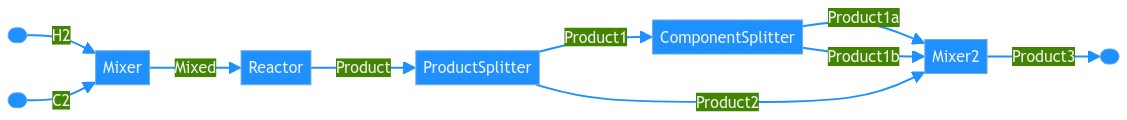

"./myflowsheet.png"

In [57]:
generateBFD(fs, "./myflowsheet.png") # Or .svg

## Mass balance boundaries

Mass balances and KPIs are defined on a boundary around a number of unit operations. We therefore define a `Boundary` and list the contained `UnitOp`s. Just like everything before, the `Flowsheet` has already created a `BoundaryList` for you: `fs.boundaries`

In [58]:
@boundary begin
    unitops --> ["Mixer", "Reactor"]
end "B1" fs

Balance Boundary:

Enclosed units: ["Mixer", "Reactor"]

Closure:
┌─────────────────────┬────────────────────┐
│           timestamp │ Total Mass Closure │
│      Dates.DateTime │            Float64 │
├─────────────────────┼────────────────────┤
│ 0000-01-01T00:00:00 │                1.0 │
└─────────────────────┴────────────────────┘

Combined Feed Mass Flows:
┌─────────────────────┬──────────┬─────────┬──────────┬──────────┬─────────┐
│           timestamp │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │   Argon │
│      Dates.DateTime │  Float64 │ Float64 │  Float64 │  Float64 │ Float64 │
├─────────────────────┼──────────┼─────────┼──────────┼──────────┼─────────┤
│ 0000-01-01T00:00:00 │   2.8053 │ 27.0619 │  2.21738 │      0.0 │     0.0 │
└─────────────────────┴──────────┴─────────┴──────────┴──────────┴─────────┘
Combined Product Mass Flows:
┌─────────────────────┬──────────┬─────────┬──────────┬──────────┬─────────┐
│           timestamp │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │   

We can look at total mass and elemental closures, as well as the combined in- and outflows.

In [59]:
fs.boundaries["B1"].atomclosures

1×1 TimeSeries.TimeArray{Dict{String, Float64}, 1, Dates.DateTime, Vector{Dict{String, Float64}}} 0000-01-01T00:00:00 to 0000-01-01T00:00:00
┌─────────────────────┬───────────────────────────────────────────────┐
│                     │ Elemental Closures                            │
├─────────────────────┼───────────────────────────────────────────────┤
│ 0000-01-01T00:00:00 │ Dict("C"=>1.0, "N"=>0.0, "Ar"=>0.0, "H"=>1.0) │
└─────────────────────┴───────────────────────────────────────────────┘

In [60]:
fs.boundaries["B1"].closure

1×1 TimeSeries.TimeArray{Float64, 1, Dates.DateTime, Vector{Float64}} 0000-01-01T00:00:00 to 0000-01-01T00:00:00
┌─────────────────────┬────────────────────┐
│                     │ Total Mass Closure │
├─────────────────────┼────────────────────┤
│ 0000-01-01T00:00:00 │                1.0 │
└─────────────────────┴────────────────────┘

In [61]:
fs.boundaries["B1"].total_in.totalmassflow

1×1 TimeSeries.TimeArray{Float64, 1, Dates.DateTime, Vector{Float64}} 0000-01-01T00:00:00 to 0000-01-01T00:00:00
┌─────────────────────┬────────────────┐
│                     │ totalmassflows │
├─────────────────────┼────────────────┤
│ 0000-01-01T00:00:00 │        32.0846 │
└─────────────────────┴────────────────┘

In [62]:
fs.boundaries["B1"].total_out.totalmassflow

1×1 TimeSeries.TimeArray{Float64, 1, Dates.DateTime, Vector{Float64}} 0000-01-01T00:00:00 to 0000-01-01T00:00:00
┌─────────────────────┬────────────────┐
│                     │ totalmassflows │
├─────────────────────┼────────────────┤
│ 0000-01-01T00:00:00 │        32.0846 │
└─────────────────────┴────────────────┘

We can also define KPIs on the boundary. Here we use the pre-defined KPIs of `conversion(boundary, component)` and `selectivity(boundary, reactant, product)`

In [63]:
conversion(fs.boundaries["B1"], "Ethane")

-0.11111111111111106

Note the convention: ethane was produced, not consumed, so has a negative value for conversion.

We can also get a number of KPIs in one call, buy passing the call in a `Tuple`, by simply separating the calls with commas:

In [64]:
conversion(fs.boundaries["B1"], "Ethylene"), conversion(fs.boundaries["B1"], "Hydrogen")

(1.0, 0.09090909090909104)

We had complete conversion of ethylene and only ~9% of hydrogen, due to the large excess fed.

What is the selectivity of converted ethylene to ethane?

In [65]:
molar_selectivity(fs.boundaries["B1"], "Ethylene", "Ethane")

0.9999999999999998

All of the reacted ethylene was converted to ethane, to within the 64-bit precision we use to calculate the results.

### For streams with time series data

Now we can repeat this for streams with multiple historic data points attached to them.
Remember that a `Flowsheet` enforces that all streams share the same components and timestamps. This means that we can't add streams with multiple data to our current flowsheet.
We first need to delete all of our streams. These streams were connected to unit ops, and the unit ops were in mass balance boundaries, so we need to also delete all of those.
We are only keeping the components!

There are a few functions we can call to delete things:
- `deletestreams!(fs)` to delete all the streams
- `deletestream!(fs, name)` to delete only a single stream (specified by name)
- `deleteunitops!(fs)` to delete all of the unit operations
- `deleteunitop!(fs, name)` to delete only the single specified unit operation
- `deleteboundary!(fs, name)` to delete only the single specified mass balance boundary
- `deleteboundaries!(fs)` to delete all of the mass balance boundaries

Since deleting a stream will corrupt any unit operations it is connected to, the function will also delete all of these streams
Similarly, deleting a unit operation will corrupt any mass balance boundaries it is included in, so they also get deleted.
This means that a call to `deletestreams()` will delete all of the streams, and all of the mass balance boundaries as well!

In [66]:
deletestreams!(fs)

We can also delete components with:
- `deletecomponent!(fs, name)` to delete only the specified component
- `deletecomponents!(fs)` to delete all of the components

Remember however that all streams contain all components, so deleting any component will cascade into deleting all streams, unit operations and boundaries as well!

In [67]:
readstreamhistory!(fs, "C2", joinpath("streamhistories", "C2.csv"); ismoleflow=true)
readstreamhistory!(fs, "H2", joinpath("streamhistories", "Hydrogen.csv"); ismoleflow=true)
readstreamhistory!(fs, "Product", joinpath("streamhistories", "Product.csv"); ismoleflow=true)
addemptystream!(fs, "Mixed");
addemptystream!(fs, "Product1");
addemptystream!(fs, "Product1a");
addemptystream!(fs, "Product1b");
addemptystream!(fs, "Product2");
addemptystream!(fs, "Product3");

And just to show what happens when we create a fixed composition stream when the streams in the flowsheet have time series data:

In [68]:
addfixedstream!(fs, "Dummy", [10.0, 0.0, 0.0, 0.0, 0.1])
fs.streams["Dummy"]

Stream: Dummy

Mass flows:
┌─────────────────────┬──────────┬─────────┬──────────┬──────────┬─────────┐
│           timestamp │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │   Argon │
│      Dates.DateTime │  Float64 │ Float64 │  Float64 │  Float64 │ Float64 │
├─────────────────────┼──────────┼─────────┼──────────┼──────────┼─────────┤
│ 2020-01-01T00:00:00 │     10.0 │     0.0 │      0.0 │      0.0 │     0.1 │
│ 2020-01-01T06:00:00 │     10.0 │     0.0 │      0.0 │      0.0 │     0.1 │
│ 2020-01-02T00:00:00 │     10.0 │     0.0 │      0.0 │      0.0 │     0.1 │
│ 2020-01-02T06:00:00 │     10.0 │     0.0 │      0.0 │      0.0 │     0.1 │
│ 2020-01-03T00:00:00 │     10.0 │     0.0 │      0.0 │      0.0 │     0.1 │
│          ⋮          │    ⋮     │    ⋮    │    ⋮     │    ⋮     │    ⋮    │
└─────────────────────┴──────────┴─────────┴──────────┴──────────┴─────────┘
                                                             22 rows omitted

Molar flows:
┌─────────────────────┬──────────┬─

In [69]:
deletestream!(fs, "Dummy")

In [70]:
@unitop begin
    inlets --> ["H2", "C2"]
    outlets --> ["Mixed"]
    calc --> mixer!
end "Mixer" fs
fs.unitops["Mixer"]()

@unitop begin
    inlets --> ["Mixed"]
    outlets --> ["Product"]
end "Reactor" fs

@unitop begin
    inlets --> ["Product"]
    outlets --> ["Product1", "Product2"]
    calc --> flowsplitter!
    params --> [0.5]
end "ProductSplitter" fs
fs.unitops["ProductSplitter"]()

@unitop begin
    inlets --> ["Product1"]
    outlets --> ["Product1a", "Product1b"]
    calc --> componentplitter!
    params --> Dict([
        "Hydrogen" => Dict(["Product1a" => 0.5]),
        "Ethane" => Dict(["Product1b" => 0.3])
    ])
end "ComponentSplitter" fs
fs.unitops["ComponentSplitter"]()

@unitop begin
    inlets --> ["Product1a", "Product1b", "Product2"]
    outlets --> ["Product3"]
    calc --> mixer!
end "Mixer2" fs
fs.unitops["Mixer2"]()

Check that the two streams have the same flows.

In [71]:
fs.streams["Product"] ≈ fs.streams["Product3"]

true

Define the mass balance boundary for closures and KPIs

In [72]:
@boundary begin
    unitops --> ["Mixer", "Reactor"]
end "B1" fs

fs.boundaries["B1"].atomclosures

fs.boundaries["B1"].closure

fs.boundaries["B1"].total_in.totalmassflow

fs.boundaries["B1"].total_out.totalmassflow

c1 = conversion(fs.boundaries["B1"], "Ethane")

c2 = conversion(fs.boundaries["B1"], "Ethylene")

sc2 = molar_selectivity(fs.boundaries["B1"], "Ethylene", "Ethane")

(mean(values(c1)), mean(values(c2)), mean(values(sc2)))

(-0.11361804202204312, 0.9988638054742306, 0.9999999999999998)

So, we have average conversions of ethane (-11.36%, meaning it was produced, not consumed), ethylene (99.9%) and selectivity of ethylene conversion to ethane (~100%) similar to the single data point above.

## Mass balance reconciliation

A robust mass balance reconciliation method is provded, but additional methods can be easily added, in a way that is mostly transparent to the end-user.
To demomstrate the use of the reconciliation tool, let's start with a new flowsheet, similar to what we have been looking at so far.

In [73]:
fs = Flowsheet()

count = readcomponentlist!(fs, "components", ["Ethylene", "Ethane", "Hydrogen", "Nitrogen", "Argon"])

readstreamhistory!(fs, "C2", joinpath("streamhistories", "C2.csv"); ismoleflow=true)
readstreamhistory!(fs, "H2", joinpath("streamhistories", "Hydrogen.csv"); ismoleflow=true)
readstreamhistory!(fs, "Product", joinpath("streamhistories", "Product.csv"); ismoleflow=true)
addemptystream!(fs, "Mixed");
addemptystream!(fs, "Product1");
addemptystream!(fs, "Product1a");
addemptystream!(fs, "Product1b");
addemptystream!(fs, "Product2");
addemptystream!(fs, "Product3");
addemptystream!(fs, "Product4");

addfixedstream!(fs, "Dummy", [10.0, 0.0, 0.0, 0.0, 0.1])

Now add the flowsheet
The two feed streams are mixed:

In [74]:
@unitop begin
    inlets --> ["H2", "C2"]
    outlets --> ["Mixed"]
    calc --> mixer!
end "Mixer" fs
fs.unitops["Mixer"]()

Now an undefined reactor block. We don't need more detail, since we have the data for the outlet stream, Product.

In [75]:
@unitop begin
    inlets --> ["Mixed"]
    outlets --> ["Product"]
end "Reactor" fs

We split this stream 50:50 intop Product1 and Product2.

In [76]:
@unitop begin
    inlets --> ["Product"]
    outlets --> ["Product1", "Product2"]
    calc --> flowsplitter!
    params --> [0.5]
end "ProductSplitter" fs
fs.unitops["ProductSplitter"]()

Now we have a separation train that splits the Product stream. The Hydrogen splits 50:50, the Ethane 30:70 and everything else 0:100 into Product1a and Product1b

In [77]:
@unitop begin
    inlets --> ["Product1"]
    outlets --> ["Product1a", "Product1b"]
    calc --> componentplitter!
    params --> Dict([
        "Hydrogen" => Dict(["Product1a" => 0.5]),
        "Ethane" => Dict(["Product1b" => 0.3])
    ])
end "ComponentSplitter" fs
fs.unitops["ComponentSplitter"]()

For reasons unknown, we mix three of the streams again.

In [78]:
@unitop begin
    inlets --> ["Product1a", "Product1b", "Product2"]
    outlets --> ["Product3"]
    calc --> mixer!
end "Mixer2" fs
fs.unitops["Mixer2"]()

fs.streams["Product"] ≈ fs.streams["Product3"]

true

And now, for something new, we add a stoichiometric reactor block.
This block takes an array of reactions and a fractional conversion for a key component for each of these reactions.
Let's define one reaction as an example:

In [79]:
EthyleneHydrogenation(frac) = Reaction(fs, ["Ethylene", "Hydrogen"], ["Ethane"], [1.0, 1.0], [1.0], "Ethylene", frac)

EthyleneHydrogenation (generic function with 1 method)

We define the reaction in the form of a Julia function, that takes a parameter for the fractional conversion of the key component.
    `EthyleneHydrogenation(frac) = ...`
In the body of the function, we call the constructor for a Reaction object.
Because we use this function form, reactions are not stored in a container, as we did with components, streams and boundaries.
We do need to pass a flowsheet object, since the components are defined in the flowsheet. We then specify an array of reactant names, an array of product names, the stoichiometric coefficients for the reactants, and for the products.
We also specify the name of the key component and its fractional conversion. All of these variables are "captured" in the function.
The constructor for a Reactio object will do a stoichiometry check to make sure the reaction is balanced.

To specify that the `UnitOp` is a stoichiometric reactor, we use the `calc` keyword, and pass an array of reaction functions as the `params`. Here, this array only has the single entry.
Reaction will be execute in parallel. If more than one reaction has the same key component, the reactor will verify that there is at most complete conversion.
This means that if you specify two reactions with the same key component, where the concersions add up to more than 1.0, you will get an error.

In [80]:
@unitop begin
    inlets --> ["Product3"]
    outlets --> ["Product4"]
    calc --> stoichiometric_reactor!
    params --> [EthyleneHydrogenation(0.5)]
end "Reactor2" fs
fs.unitops["Reactor2"]()

We can do a quick check on our flowsheet:

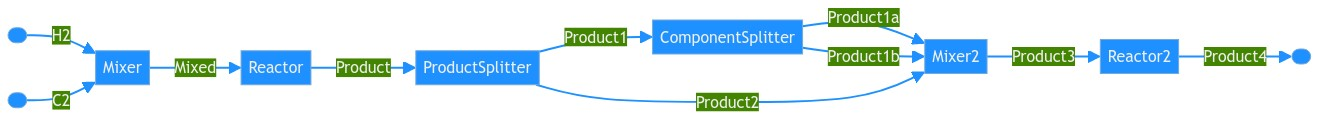

"./myflowsheet2.png"

In [81]:
generateBFD(fs, "./myflowsheet2.png") # Or .svg

Now let's introduce a measurement error in the 'Mixed' stream:

In [82]:
fs.streams["Mixed"] = 1.1*fs.streams["Mixed"]

Stream: Mixed

Mass flows:
┌─────────────────────┬──────────┬─────────┬──────────┬──────────┬─────────┐
│           timestamp │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │   Argon │
│      Dates.DateTime │  Float64 │ Float64 │  Float64 │  Float64 │ Float64 │
├─────────────────────┼──────────┼─────────┼──────────┼──────────┼─────────┤
│ 2020-01-01T00:00:00 │  3.30921 │ 29.5193 │  2.47734 │      0.0 │     0.0 │
│ 2020-01-01T06:00:00 │   3.3135 │ 29.6602 │   2.4333 │      0.0 │     0.0 │
│ 2020-01-02T00:00:00 │  2.84452 │ 32.5956 │  2.44395 │      0.0 │     0.0 │
│ 2020-01-02T06:00:00 │  3.27379 │  32.101 │  2.43045 │      0.0 │     0.0 │
│ 2020-01-03T00:00:00 │  3.19165 │ 30.5383 │   2.4689 │      0.0 │     0.0 │
│          ⋮          │    ⋮     │    ⋮    │    ⋮     │    ⋮     │    ⋮    │
└─────────────────────┴──────────┴─────────┴──────────┴──────────┴─────────┘
                                                             22 rows omitted

Molar flows:
┌─────────────────────┬──────────┬─

We are going to define two balance boundaries.
- B1 includes the first mixer: 'Mixer'
- B2 includes the first reactor ('Reactor') and the first splitter (`ProductSplitter`)
This means that our stream with the measurement error is a stream linking the two boundaries.

In [83]:
@boundary begin
    unitops --> ["Mixer"]
end "B1" fs

@boundary begin
    unitops --> ["Reactor", "ProductSplitter"]
end "B2" fs

fs.boundaries["B1"]

Balance Boundary:

Enclosed units: ["Mixer"]

Closure:
┌─────────────────────┬────────────────────┐
│           timestamp │ Total Mass Closure │
│      Dates.DateTime │            Float64 │
├─────────────────────┼────────────────────┤
│ 2020-01-01T00:00:00 │                1.1 │
│ 2020-01-01T06:00:00 │                1.1 │
│ 2020-01-02T00:00:00 │                1.1 │
│ 2020-01-02T06:00:00 │                1.1 │
│ 2020-01-03T00:00:00 │                1.1 │
│          ⋮          │         ⋮          │
└─────────────────────┴────────────────────┘
                             22 rows omitted

Combined Feed Mass Flows:
┌─────────────────────┬──────────┬─────────┬──────────┬──────────┬─────────┐
│           timestamp │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │   Argon │
│      Dates.DateTime │  Float64 │ Float64 │  Float64 │  Float64 │ Float64 │
├─────────────────────┼──────────┼─────────┼──────────┼──────────┼─────────┤
│ 2020-01-01T00:00:00 │  3.00838 │ 26.8357 │  2.25213 │      0.0 │    

In [84]:
fs.boundaries["B2"]

Balance Boundary:

Enclosed units: ["Reactor", "ProductSplitter"]

Closure:
┌─────────────────────┬────────────────────┐
│           timestamp │ Total Mass Closure │
│      Dates.DateTime │            Float64 │
├─────────────────────┼────────────────────┤
│ 2020-01-01T00:00:00 │           0.909091 │
│ 2020-01-01T06:00:00 │           0.909091 │
│ 2020-01-02T00:00:00 │           0.909091 │
│ 2020-01-02T06:00:00 │           0.909091 │
│ 2020-01-03T00:00:00 │           0.909091 │
│          ⋮          │         ⋮          │
└─────────────────────┴────────────────────┘
                             22 rows omitted

Combined Feed Mass Flows:
┌─────────────────────┬──────────┬─────────┬──────────┬──────────┬─────────┐
│           timestamp │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │   Argon │
│      Dates.DateTime │  Float64 │ Float64 │  Float64 │  Float64 │ Float64 │
├─────────────────────┼──────────┼─────────┼──────────┼──────────┼─────────┤
│ 2020-01-01T00:00:00 │  3.30921 │ 29.5193 │  2.4

This choice of the boundaries is not ideal, as there is no unique solution. We can however tell the optimiser that we have faith in one stream. This stream may be measured by a high fidelity instrument like a coriolis type flow meter.
We call a stream that will remain fixed during the reconciliation an 'anchor' stream. Specifying an anchor is optional.

In [85]:
corrections = calccorrections(fs; λ = 0.0, anchor = "H2");

This returns a `Dictionary` of stream => correction factor.
You may be wondering what the `λ` parameter is. The 'calccorrections' function takes quite a few paramaters, but most of them have default values:
    function calccorrections(fs; customerror=nothing, anchor = nothing, totalweight=1.0, elementweight = 1.0,
      setelements = false, elementweights::Dict{String, Float64} = Dict{String, Float64}(), λ = 0.1)
- customerror: a user-supplied function that can add a custom error to be minimised during the reconciliation. For example, you may want to ensure that the reconiled result for your reactor outlet is in chemical equilibrium. You can then pass the deviation from equilibrium as the custom error.
- anchor: a stream that will remain fixed during the reconciliation.
- totalweight: the weight applied the total mass balance error. Default value is 1.0
- elementweight: the weight applied to each element balance error. Each element error gets the same weight with a default value of 1.0.
- setelements: if true, the dictionary of weights for each element is applied, rather than value of *elementweights*. This dictionary is passed in `elementweights`.
- elementweights: (note the plural!) a dictionary of element => weight. Default value is an empty dictionary. This allows each element closure error to be weighted separately and some elements errors to be ignored, by setting these weights to 0.0.
- λ: the regularisation parameter for (L₂ Regularisation)[https://en.wikipedia.org/wiki/Ridge_regression#Tikhonov_regularization]. Default value is 0.1.

The regularisation adds the sum of the squared corrections to the error that is to be minimised, weighted by λ. This means that the solver strives to minimise the adjustments to the flows while reconciling the mass balance.
Regularisation is a trade-off. Use it when you see suspiciouly large corrections. If used when not needed, it will may worse reconciliations.

In [86]:
corrections

Dict{String, Float64} with 4 entries:
  "C2"       => 1.0
  "Product1" => 1.0
  "Mixed"    => 0.909091
  "Product2" => 1.0

Now that we have the corrections, we can choose to apply them to our streams by calling `closemb!(fs, corrections)`.
We'll apply the correction in a short while, but first, lets look at what else `calccorrections` can do.

Let's first look at that custom error function in a bit more detail.
This function takes the form:

In [87]:
myerr(dict) = 0.01 * sum(abs2, 1.0 .- (values(dict))) # Fudging the Ridge Regression, with a lambda of 0.01.

myerr (generic function with 1 method)

where the dict is a dictionary of stream => correction factor pairs. These corrections are the values at each step in the optimisation and the custom error function must multiply the stream flows with them before doing any additional calculations.
This is needed, since we won't know what the final resuls of the corrections will be, and hence cannot apply the factors to the streams before the end.
The function can now calculate any value from the streams flows and compositions, e.g. a distance from equilibrium for a reaction. It returns a scalar value, that is added to the weighted sum of errors for the total mass balance and elemental balance errors. No further weighting is done.
We just pass the function in the `customerror` argument.

In [88]:
corrections2 = calccorrections(fs, anchor="H2", customerror=myerr)

Dict{String, Float64} with 4 entries:
  "C2"       => 1.01016
  "Product1" => 1.00914
  "Mixed"    => 0.917418
  "Product2" => 1.00914

The previous examples uses a constant weight for all elements, but we can specifiy individual weights as well.

In [89]:
weights = Dict(["H" => 1.0, "C" => 1.5, "O" => 1.0, "Ar" => 0.0, "N" => 0.0])
corrections3 = calccorrections(fs, λ = 0.0, anchor = "H2", setelements=true, elementweights=weights)

closemb!(fs, corrections)

This modifies the streams. We can check the result:

In [90]:
fs.boundaries["B1"]
fs.boundaries["B2"]

Balance Boundary:

Enclosed units: ["Reactor", "ProductSplitter"]

Closure:
┌─────────────────────┬────────────────────┐
│           timestamp │ Total Mass Closure │
│      Dates.DateTime │            Float64 │
├─────────────────────┼────────────────────┤
│ 2020-01-01T00:00:00 │                1.0 │
│ 2020-01-01T06:00:00 │                1.0 │
│ 2020-01-02T00:00:00 │                1.0 │
│ 2020-01-02T06:00:00 │                1.0 │
│ 2020-01-03T00:00:00 │                1.0 │
│          ⋮          │         ⋮          │
└─────────────────────┴────────────────────┘
                             22 rows omitted

Combined Feed Mass Flows:
┌─────────────────────┬──────────┬─────────┬──────────┬──────────┬─────────┐
│           timestamp │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │   Argon │
│      Dates.DateTime │  Float64 │ Float64 │  Float64 │  Float64 │ Float64 │
├─────────────────────┼──────────┼─────────┼──────────┼──────────┼─────────┤
│ 2020-01-01T00:00:00 │  3.00838 │ 26.8357 │  2.2

We can now write corrected streams back to file

In [91]:
writestreamhistory(fs.streams["C2"], "corrected.csv")

We can also request some information from a bounary. This is given in table form, packed into a string.

In [92]:
print(showdata(fs.boundaries["B2"]))

Mass Balance Boundary:
----------------------

Total Mass Flows In:
┌─────────────────────┬──────────┬─────────┬──────────┬──────────┬─────────┐
│           timestamp │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │   Argon │
│      Dates.DateTime │  Float64 │ Float64 │  Float64 │  Float64 │ Float64 │
├─────────────────────┼──────────┼─────────┼──────────┼──────────┼─────────┤
│ 2020-01-01T00:00:00 │  3.00838 │ 26.8357 │  2.25213 │      0.0 │     0.0 │
│ 2020-01-01T06:00:00 │  3.01228 │ 26.9638 │  2.21209 │      0.0 │     0.0 │
│ 2020-01-02T00:00:00 │  2.58593 │ 29.6324 │  2.22177 │      0.0 │     0.0 │
│ 2020-01-02T06:00:00 │  2.97617 │ 29.1827 │   2.2095 │      0.0 │     0.0 │
│ 2020-01-03T00:00:00 │   2.9015 │ 27.7621 │  2.24445 │      0.0 │     0.0 │
│ 2020-01-03T06:00:00 │  2.87429 │ 28.5366 │  2.20218 │      0.0 │     0.0 │
│ 2020-01-04T00:00:00 │  3.08111 │ 26.6235 │  2.25736 │      0.0 │     0.0 │
│ 2020-01-04T06:00:00 │  3.04934 │ 27.1932 │  2.21476 │      0.0 │     0.0 │
│ 2020-0

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*